<a href="https://colab.research.google.com/github/AstridSerruto/Projects/blob/master/Other/Modeling_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install mmcv-full===1.8
import datetime
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns
import sklearn
import sklearn.model_selection as ms
import transformers
import time
import torch

from google.colab import drive
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 2.0MB 8.8MB/s 
     |████████████████████████████████| 3.2MB 44.7MB/s 
     |████████████████████████████████| 890kB 29.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=1b99ee9b2bcaebb9dd4eeff8d8719625ba1bdff6afa36861729e626d122d798d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: Could not find a version that satisfies the requirement mmcv-full===1.8 (from versions: 1.0rc0, 1.0rc2, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.1.6, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.2.4, 1.2.5, 1.2.6, 1.2.7)
ERROR: No matching distribution found for mmcv-full===1.8


In [ ]:
#Set pytorch to be used on GPU
device = torch.device("cuda") 

In [ ]:
# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# create folder to write data to
FakeNews_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'FN_Project')
HOMEWORK_FOLDER=os.path.join(FakeNews_FOLDER, 'FN_Project')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Mounted at /content/gdrive


In [ ]:
x_train = pd.read_csv('/content/gdrive/My Drive/Datasets/training_data.csv')
x_test = pd.read_csv('/content/gdrive/My Drive/Datasets/testing_data.csv')
y_train = pd.read_csv('/content/gdrive/My Drive/Datasets/train_labels.csv')
y_test = pd.read_csv('/content/gdrive/My Drive/Datasets/test_labels.csv')

In [ ]:
x_train.drop(columns=['Unnamed: 0'], inplace = True)
x_test.drop(columns=['Unnamed: 0'], inplace = True)
y_train.drop(columns=['Unnamed: 0'], inplace = True)
y_test.drop(columns=['Unnamed: 0'], inplace = True)

In [ ]:
fake = pd.read_csv('/content/gdrive/My Drive/Datasets/fakeForModeling.csv')
true = pd.read_csv('/content/gdrive/My Drive/Datasets/trueForModeling.csv')

In [ ]:
fake.drop(columns=['Unnamed: 0'], inplace = True)
true.drop(columns=['Unnamed: 0'], inplace = True)

Binomial Logistic Regression

In [ ]:
# Instantiate a logistic regression model
lr = LogisticRegression()

lr.fit(x_train, np.ravel(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_lr = lr.predict(x_test)

In [ ]:
lr_cm = metrics.confusion_matrix(y_test, y_pred_lr)
print (lr_cm)

[[4002  501]
 [ 452 4311]]


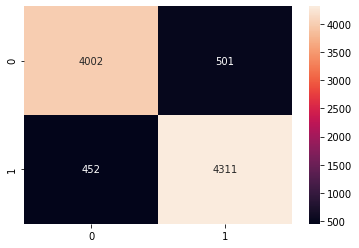

In [ ]:
labels = np.array([['4002','501'],['452','4311']])
sns.heatmap(lr_cm, annot=labels, fmt = '')
plt.show()

In [ ]:
print("Accuracy is: ", metrics.accuracy_score(y_test, y_pred_lr))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print(metrics.classification_report(y_test, y_pred_lr))

Accuracy is:  0.897150874163609
Mean Squared Error is: 0.3207009913243037
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4503
           1       0.90      0.91      0.90      4763

    accuracy                           0.90      9266
   macro avg       0.90      0.90      0.90      9266
weighted avg       0.90      0.90      0.90      9266



In [ ]:
# Calculate predicted probabilities for test data 
y_pred_prob_lr = lr.predict_proba(x_test)[:, 1]

In [ ]:
metrics.roc_auc_score(y_test, y_pred_prob_lr)

0.9568492351356124

Naive Bayes

In [ ]:
# Naive Bayes variant used in text classification
nb = MultinomialNB()
%time nb.fit(x_train, np.ravel(y_train))

CPU times: user 47.2 ms, sys: 34.3 ms, total: 81.4 ms
Wall time: 54.8 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
y_pred_class = nb.predict(x_test)

In [ ]:
nb_cm = metrics.confusion_matrix(y_test, y_pred_class)
print(nb_cm)

[[3867  636]
 [ 600 4163]]


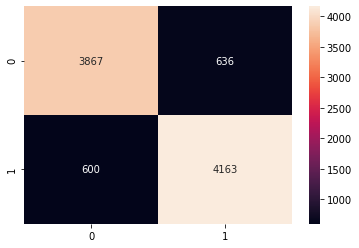

In [ ]:
labels =  np.array([['3867','636'],['600','4163']])
sns.heatmap(nb_cm, annot=labels, fmt = '')
plt.show()

In [ ]:
print("Accuracy is:", metrics.accuracy_score(y_test, y_pred_class))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_class)))
print(metrics.classification_report(y_test, y_pred_class))

Accuracy is: 0.8666091085689618
Mean Squared Error is: 0.36522717783735403
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4503
           1       0.87      0.87      0.87      4763

    accuracy                           0.87      9266
   macro avg       0.87      0.87      0.87      9266
weighted avg       0.87      0.87      0.87      9266



In [ ]:
# Calculate predicted probabilities for test data 
y_pred_prob_nb = nb.predict_proba(x_test)[:, 1]

In [ ]:
metrics.roc_auc_score(y_test, y_pred_prob_nb)

0.9338083986186174

In [ ]:
#Number of times token appears in each True article
true_token = nb.feature_count_[0, :]

#Number of times token appears in each Fake article
fake_token = nb.feature_count_[1, :]

In [ ]:
tokens = pd.DataFrame({'token':x_train.columns, 'true':true_token, 'fake':fake_token}).set_index('token')
tokens.head()

,true,fake
token,,
according,377.235192,400.582444
act,218.442881,279.650057
action,283.719241,278.586737
added,318.226860,158.187281
administration,496.370815,357.358514


In [ ]:
# Add 1 to true and fake counts to avoid dividing by 0
tokens['true'] = tokens.true + 1
tokens['fake'] = tokens.fake + 1

In [ ]:
# Convert true and fake counts into frequencies
tokens['true'] = tokens.true / nb.class_count_[0]
tokens['fake'] = tokens.fake / nb.class_count_[1]

In [ ]:
# Calculate the ratio of fake to true for each token
tokens['fake/true ratio'] = tokens.fake / tokens.true
tokens.sort_values('fake/true ratio', ascending=False).head(10)

,true,fake,fake/true ratio
token,,,
video,0.005444,0.039334,7.224719
fact,0.004140,0.025755,6.221561
hillary,0.008886,0.048162,5.420019
really,0.005028,0.025013,4.975049
know,0.008408,0.039078,4.647589
got,0.004580,0.021211,4.630964
america,0.008262,0.036754,4.448529
went,0.004647,0.019069,4.103528
story,0.005630,0.022906,4.068241


In [ ]:
tokens.sort_values('fake/true ratio', ascending=True).head(10)

,true,fake,fake/true ratio
token,,,
minister,0.049728,0.004145,0.083347
wednesday,0.039481,0.008533,0.216144
thursday,0.038052,0.008354,0.219547
tuesday,0.037339,0.009037,0.242038
monday,0.034889,0.008628,0.247286
friday,0.036617,0.009796,0.267516
foreign,0.034821,0.010403,0.298756
international,0.023276,0.007500,0.322212
military,0.036171,0.011904,0.329110


Support Vector Machines

In [ ]:
#Linear kernel fits well, decided not to use another kernel because of economy 
#and because linear has the lowest risk of overfitting
svc = SVC(kernel='linear', random_state=1) 
svc.fit(x_train, np.ravel(y_train))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred_svm = svc.predict(x_test)

In [ ]:
print("Accuracy is:", metrics.accuracy_score(y_test, y_pred_svm))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_svm)))
print(metrics.classification_report(y_test, y_pred_svm))

Accuracy is: 0.9002805957263113
Mean Squared Error is: 0.3157837935576947
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4503
           1       0.90      0.91      0.90      4763

    accuracy                           0.90      9266
   macro avg       0.90      0.90      0.90      9266
weighted avg       0.90      0.90      0.90      9266



In [ ]:
svm_cm = metrics.confusion_matrix(y_test, y_pred_svm)
print(svm_cm)

[[4006  497]
 [ 427 4336]]


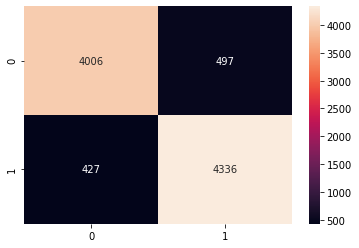

In [ ]:
labels =  np.array([['4006','497'],['427','4336']])
sns.heatmap(svm_cm, annot=labels, fmt = '')
plt.show()

In [ ]:
print (metrics.roc_auc_score(y_test, y_pred_svm))

0.8999898777445078


Random Forest

In [ ]:
#Tried different depths, 60 was the best
#Tried estimators, 200 was the best
rf = RandomForestClassifier(random_state = 1)

param_grid = {
    'n_estimators': [200],
    'max_depth': [50, 60, 70]
    }

%time grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
grid_search_rf.fit(x_train, np.ravel(y_train))
grid_search_rf.best_params_

CPU times: user 81 µs, sys: 1 µs, total: 82 µs
Wall time: 87.3 µs


{'max_depth': 70, 'n_estimators': 200}

In [ ]:
y_pred_rf = grid_search_rf.predict(x_test)

In [ ]:
rf_cm = metrics.confusion_matrix(y_test, y_pred_rf)
print(rf_cm)

[[4088  415]
 [ 221 4542]]


In [ ]:
print("Accuracy is:", metrics.accuracy_score(y_test, y_pred_rf))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print(metrics.classification_report(y_test, y_pred_rf))

Accuracy is: 0.9313619684869415
Mean Squared Error is: 0.2619886095101436
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4503
           1       0.92      0.95      0.93      4763

    accuracy                           0.93      9266
   macro avg       0.93      0.93      0.93      9266
weighted avg       0.93      0.93      0.93      9266



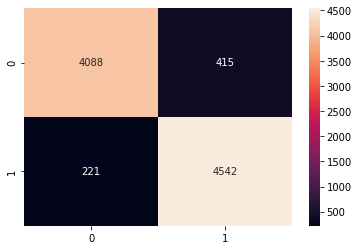

In [ ]:
labels = np.array([['4088','415'],['221','4542']])
sns.heatmap(rf_cm, annot=labels, fmt = '')
plt.show()

In [ ]:
# Calculate predicted probabilities for test data 
y_pred_prob_rf = grid_search_rf.predict_proba(x_test)[:, 1]

In [ ]:
metrics.roc_auc_score(y_test, y_pred_prob_rf)

0.9790150397320674

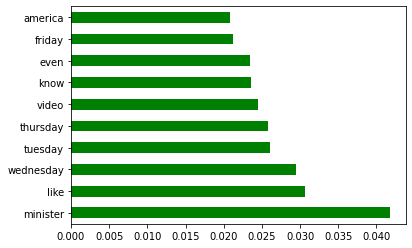

In [ ]:
feature_importances = pd.Series(grid_search_rf.best_estimator_.feature_importances_, index=x_train.columns)
feature_importances.nlargest(10).plot(kind='barh', color='green')

Neural Network

I use the basic bert-base-uncased model. The maximum number of tokens allowed for BERT is 512, so articles are truncated. This could pose a possible issue.

In [ ]:
#Create new train-test set
X = pd.concat([true["text"], fake["text"]])
true["label"] = [0 for x in true["label"]]
fake["label"] = [1 for x in fake["label"]]
y = pd.concat([true["label"], fake["label"]])

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.2, random_state=1)
train_data = pd.concat([X_train, y_train],axis = 1).reset_index(drop=True)
test_data = pd.concat([X_test, y_test],axis = 1).reset_index(drop=True)

In [ ]:
X = pd.DataFrame(X)
articles = X["text"].tolist()
y = pd.DataFrame(y)
labels = y["label"].tolist()

In [ ]:
#Create new tokenizer because it's best to tokenize with the same tokenizer 
#That BERT was trained on instead of self-defined one 

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Tokenize all of the articles and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for article in articles:
    encoded_dict = tokenizer.encode_plus(
                        article,                      #Article to encode
                        add_special_tokens = True, #Add [CLS] to start, [SEP] to end
                        max_length = 64,           #Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   #Create masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    #Add the encoded sentence to the list    
    input_ids.append(encoded_dict['input_ids'])
    
    # Add attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0) #encoded sentence
attention_masks = torch.cat(attention_masks, dim=0) #mask
labels = torch.tensor(labels) #labels (fake/true)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 70-10-20 train-validation-test split

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset)) + 1 #add 1 because int() causes 1 row to be left out
test_size = int(0.2 * len(dataset)) 

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))


ValueError: ignored

In [ ]:
#BERT developers recommend 16 or 32 batch_size
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size)

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially, since order doesn't matter here
            batch_size = batch_size)

test_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially, since order doesn't matter here
            batch_size = batch_size)


In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer  
# Don't output all layers due to memory limits
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab
    num_labels = 2, #binary classification  
    output_attentions = False, 
    output_hidden_states = False)

#run model on the GPU
model.cuda()

In [ ]:
#Use Adam optimizer
optimizer = AdamW(model.parameters(),
                  lr = 0.00002,
                  eps = 1e-8) # default is 1e-8

In [ ]:
# BERT authors recommend between 2 and 4 epochs
epochs = 4

# number of batches x number of epochs
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler to reduce the learning rate as training epochs increase
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, #default
                                            num_training_steps = total_steps)

In [ ]:
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return metrics.accuracy_score(pred_flat, labels_flat)

In [ ]:
#Takes a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
#Use a seed to ensure reproductibility
seed_val = 22

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            
            # Report progress
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device) #copy each tensor to the GPU
        b_input_mask = batch[1].to(device) #copy each tensor to the GPU
        b_labels = batch[2].to(device) #copy each tensor to the GPU

        model.zero_grad()        

        # Perform forward pass 
        # Returns the loss (because we provided labels) and the "logits" - the model
        # outputs prior to activation
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step() # Update the learning rate

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device) #copy each tensor to the GPU
        b_input_mask = batch[1].to(device) #copy each tensor to the GPU
        b_labels = batch[2].to(device) #copy each tensor to the GPU
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)         
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += accuracy(logits, label_ids)
        
    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=0.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
model.eval()

predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

print("Accuracy is:", metrics.accuracy_score(flat_predictions,flat_true_labels))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(flat_predictions, flat_true_labels)))
b_cm = metrics.confusion_matrix(flat_predictions,flat_true_labels)
print(b_cm)

In [ ]:
labels = np.array([['4519','12'],['7','4802']])
sns.heatmap(b_cm, annot=labels, fmt = '')
plt.show()

In [ ]:
print (metrics.roc_auc_score(flat_predictions, flat_true_labels))
print(metrics.classification_report(flat_predictions, flat_true_labels))